In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm 

import shapefile as shp

from esda.moran import Moran
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen

from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import splot
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


### Convert Census Blocks to Census Tracts 

In [2]:
for y in tqdm(range(2002,2003)):
    name='Data/RAC/tx_rac_S000_JT00_'+str(y)+'.csv'
    df=pd.read_csv(name)
    
    # from census blocks too census tracts
    df['h_geocode']=df['h_geocode'].astype(str)
    df['h_geocode_tract'] = df.h_geocode.str.slice(0, 11)
    df=df.groupby(['h_geocode_tract']).sum().reset_index()


    # rename the columns from codes to names
    df=df[['h_geocode_tract','C000','CNS01','CNS02','CNS03','CNS04','CNS05','CNS06','CNS07','CNS08','CNS09','CNS10',
 'CNS11','CNS12','CNS13','CNS14','CNS15','CNS16','CNS17','CNS18','CNS19','CNS20']]
    df.columns=['h_geocode_tract','total','Agriculture; Forestry; Fishing; and Hunting','Mining; Quarrying; and Oil and Gas Extraction',
  'Utilities','Construction','Manufacturing','Wholesale Trade','Retail Trade','Transportation and Warehousing',
 'Information','Finance and Insurance','Real Estate and Rental and Leasing',
  'Professional; Scientific; and Technical Services','Management of Companies and Enterprises','Administrative and Support Services',
  'Educational Services','Health Care and Social Assistance','Arts; Entertainment; and Recreation','Accommodation and Food Services'
  ,'Other Services (Except Public Administration)','Public Administration' ]




100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


### Calculate skill composition


In [3]:
sector=pd.read_csv('Data/sectors_percentage.csv')
sector=sector.fillna(0)
sector[['cognitive','physical']]=sector[['cognitive','physical']]/100

In [4]:
for y in tqdm(range(2002,2003)):
    sector[['cognitive','physical']]=sector[['cognitive','physical']]
    df=df.set_index('h_geocode_tract')
    skills=df[['total']]
    df=df.drop('total',axis=1)
    cog=pd.DataFrame(np.round((df.values* list(sector.cognitive))))
    phys=pd.DataFrame(np.round((df.values* list(sector.physical))))
    cog_tract=cog.sum(min_count=0,skipna=False,axis=1).to_frame()
    phys_tract=phys.sum(min_count=0,skipna=False,axis=1).to_frame()
    skills['h_physical']=phys_tract.values
    skills['h_cognitive']=cog_tract.values
    skills['h_%physical']=skills['h_physical']/skills['total']*100
    skills['h_%cognitive']=skills['h_cognitive']/skills['total']*100
    skills['h_total']=skills['total']




100%|██████████| 1/1 [00:00<00:00, 72.90it/s]


### Merge to our area of study 

In [5]:
locations=pd.read_csv('Data/tx_coords_dallas.csv')

In [6]:
skills=skills.reset_index()


In [7]:
skills.h_geocode_tract=skills.h_geocode_tract.astype(str)
locations.Id=locations.Id.astype(str)

In [8]:
geo_tagged_skills=skills.merge(locations,left_on='h_geocode_tract',right_on='Id')

### Map Zip codes to tracts for housing prices and CBP

In [9]:
Home_prices = pd.read_csv('Data/Zip_Zhvi_AllHomes.csv') #1996-01 to 2020-03, 24Years, monthly
Home_prices = Home_prices[Home_prices['State']=='TX']
Home_prices = Home_prices.set_index('RegionName').sort_index()

In [10]:
tracts_zipcode_conversion = pd.read_excel('Data/TRACT_ZIP_062020.xlsx')
tracts_zipcode_conversion = tracts_zipcode_conversion.rename({'ZIP': 'RegionName', 'TRACT':'Id'}, axis=1)

In [11]:
locations_ = locations.copy()
locations_['Id'] = locations_['Id'].astype(int)

In [12]:
tx_tracts_zipcode_conversion = tracts_zipcode_conversion.merge(locations_,on='Id').set_index('RegionName').sort_index()

In [13]:
tract_house_price = tx_tracts_zipcode_conversion.merge(Home_prices,on='RegionName').set_index('Id').sort_index()
tract_house_price = tract_house_price.drop(tract_house_price.columns[[4,5,6,7,8,9,10,11,12,13]], axis=1)
tract_house_price = tract_house_price.fillna(0)

In [14]:
tract_house_price_ = tract_house_price.iloc[:,4:]
tract_house_price_r = tract_house_price.iloc[:,:4]
tract_house_price_r_ = tract_house_price.iloc[:,3]

# aggregating all the tracts ratios 
tract_house_price_.multiply(tract_house_price_r_.values, axis=0)
tract_house_price_ = pd.concat([tract_house_price_r, tract_house_price_], axis =1)
tract_house_price_ = tract_house_price_.groupby('Id').sum()

In [15]:
tract_house_price_y = tract_house_price_.iloc[:,4:].groupby(by=lambda x: x.split('-')[0], axis=1).mean()

### Inflation

In [16]:
CPI = pd.read_csv('Data/CPI_US.csv')
CPI.set_index('Year', inplace=True)

In [17]:
CPI.columns = range(1, 13)

In [18]:
s = CPI.stack()
year = s.index.get_level_values(0).values
month = s.index.get_level_values(1).values
s.index = pd.PeriodIndex(year=year, month=month, freq='M')

In [19]:
CPI_d = pd.DataFrame(s)
CPI_d.columns = ['CPI']

In [20]:
CPI_d = CPI_d.iloc[996:,:]

In [21]:
CPI_d_y = CPI_d.iloc[:,:].groupby(by=lambda x: str(x).split('-')[0], axis=0).mean()

In [22]:
Raw_home_prices = tract_house_price_y.replace(np.nan, 0).T

In [23]:
CPI_d_y['CPI_Multiplier'] = CPI_d_y['CPI'].iloc[-1] / CPI_d_y['CPI']

In [24]:
Adjusted_home_prices = Raw_home_prices.T*CPI_d_y['CPI_Multiplier'].values

### Establishments 

In [25]:
# Reading number of establishments, yearly resolution

est = pd.DataFrame()
for y in ['96','97','98','99','00','01','02','03','04','05','06','07','08','09']:
    file = pd.read_csv('Data/Establishments/zbp'+y+'totals.txt')
    file.columns = map(str.lower, file.columns)
    file = file.set_index('zip').sort_index()
    file['city'], file['stabbr'] = file['name'].str.split(',', 1).str
    file['stabbr'] = file['stabbr'].str.replace(' ', '')
    file = file[file.stabbr=='TX']['est'].to_frame().rename({'est': y}, axis=1)
    est = pd.concat([est,file],axis=1,join='outer')
    est
for y in ['10','11','12','13','14','15','16','17']:
    file = pd.read_csv('Data/Establishments/zbp'+y+'totals.txt')
    file = file.set_index('zip').sort_index()
    file = file[file.stabbr=='TX']['est'].to_frame().rename({'est': y}, axis=1)
    est  = pd.concat([est,file],axis=1,join='outer')
    est
years = ['1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009',
         '2010','2011','2012','2013','2014','2015','2016','2017']

est.columns=  years

/Users/shahadalthobaiti/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


In [26]:
est = est.reset_index().rename({'zip': 'RegionName'}, axis=1).set_index('RegionName').sort_index()

In [27]:
tract_est = tx_tracts_zipcode_conversion.merge(est,on='RegionName').set_index('Id').sort_index()
tract_est = tract_est.fillna(0)

In [28]:
tract_est_ = tract_est.iloc[:,6:]
tract_est_r = tract_est.iloc[:,:4]
tract_est_r_ = tract_est.iloc[:,3]


# aggregating all the tracts ratios 
tract_est_ = tract_est_.multiply(tract_est_r_.values, axis=0)
tract_est_ = pd.concat([tract_est_r, tract_est_], axis =1)
tract_est_ = tract_est_.groupby('Id').sum()


In [29]:
tx_est = tract_est_.iloc[:,4:]

## Analysis

### Visualize skill distribution

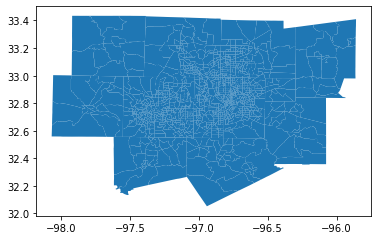

In [30]:

map_df = gpd.read_file('Data/shapefiles/cbsa_trcats_tx.shp')
map_df.GEOID10=map_df.GEOID10.astype(str)


map_df.plot()
plt.grid(b=False)




df = read_shapefile(shapefile)
df.shape
len(df)

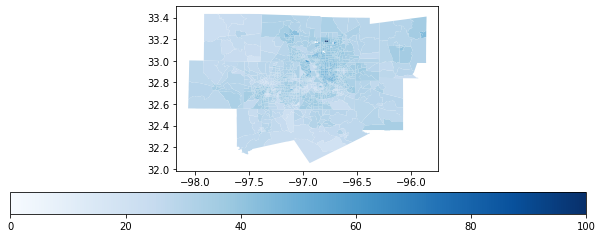

In [31]:
scaler = MinMaxScaler()
geo_tagged_skills['no_skill_c'] = scaler.fit_transform(geo_tagged_skills['h_%cognitive'].values.reshape(-1,1))


merged=map_df.merge(geo_tagged_skills,left_on='GEOID10',right_on='h_geocode_tract')
merged['no_skill_c']=merged['no_skill_c'].replace(0,merged['no_skill_c'].mean())
merged['no_skill_c']=merged['no_skill_c'].fillna(merged['no_skill_c'].mean())
merged=merged.drop_duplicates('GEOID10')


fig, ax = plt.subplots(figsize=(10, 6))
fig.subplots_adjust(bottom=0.5)
ax.grid(False)


cmap = mpl.cm.Blues
norm = mpl.colors.Normalize(vmin=0, vmax=100)



merged.plot(column='no_skill_c', cmap=cmap,ax=ax,linewidth=0.8, edgecolor='none')


cax = plt.axes([0.1, 0.4, 0.8, 0.05])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
     cax=cax, orientation='horizontal')

plt.show()



### Calculate Spatial Autocorrelation

Global moran's I: 0.5456723273985968


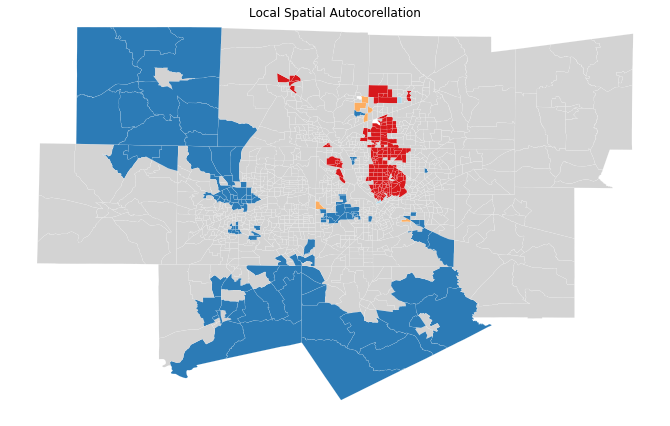

In [32]:
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler


fig, ax = plt.subplots(figsize=(10, 6))
fig.subplots_adjust(bottom=0.5)


y = merged['h_%cognitive'].values
w = Queen.from_dataframe(merged)

# Global moran's I
moran = Moran(y, w)
print('Global moran\'s I: '+str(moran.I))

# Local moran's I
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, merged,ax=ax, p=0.01,legend=False)


plt.suptitle('Local Spatial Autocorellation',fontsize=12)

plt.tight_layout()
plt.show()


### Linear Regression 
#### merge centrality with housing and CBP varibales along with skills 
##### *centrality and other network analysis have been done on Gephi- https://gephi.org

In [33]:
dft1 = Adjusted_home_prices
dft2 = tx_est
dft3 = pd.read_csv('Data/all_year_eigenvector_centrality_tx.csv').rename(columns={'tract': 'TRACT'}).set_index('TRACT').sort_index()


In [34]:
indext = dft1.index

In [35]:
dft2 = dft2.loc[dft1.index]

In [36]:
dft3 = dft3.loc[dft1.index]

In [37]:
dft1=dft1.iloc[:,6:-3].stack().to_frame().reset_index()
dft1.columns=['TRACT', 'year', 'house_price']

dft2=dft2.iloc[:,6:].stack().to_frame().reset_index()
dft2.columns=['TRACT', 'year', 'est']
dft3 = dft3.reset_index()

### Adding Skills to the variables

In [38]:
skillst=pd.read_csv('Data/all_years_skills_tx.csv')

In [39]:
skillst.drop(['total','h_physical','h_cognitive','h_%physical','h_total'], axis=1, inplace=True)

In [40]:
skillst.columns=['TRACT', 'cognitive_fraction', 'year']
skillst.TRACT=skillst.TRACT.astype(str)
skillst.year=skillst.year.astype(str)

In [41]:
dft1.TRACT = dft1.TRACT.astype(str)
dft2.TRACT = dft2.TRACT.astype(str)
dft3.TRACT = dft3.TRACT.astype(str)

dft1.year = dft1.year.astype(str)
dft2.year = dft2.year.astype(str)
dft3.year = dft3.year.astype(str)

In [42]:
mer_tx = dft1.merge(skillst,on=['TRACT','year'])
mer_tx = dft2.merge(mer_tx,on=['TRACT','year'])
mer_tx = dft3.merge(mer_tx,on=['TRACT','year'])

In [43]:
# Adding city column
mer_tx['DL'] = 1

### Regression Analysis

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.preprocessing import normalize
from statsmodels.formula.api import ols


In [45]:
from sklearn.preprocessing import MaxAbsScaler

# create an abs_scaler object
abs_scaler = MaxAbsScaler()

# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler.fit(mer_tx)

# the maximum absolute values calculated by the fit method
abs_scaler.max_abs_

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler.transform(mer_tx)

# store the results in a data frame
df_scaled = pd.DataFrame(scaled_data, columns=mer_tx.columns)


In [46]:
reg1  = ols("house_price ~ eigenvector_centrality", data = df_scaled).fit()
reg2  = ols("house_price ~ cognitive_fraction", data = df_scaled).fit()
reg3  = ols("house_price ~ est", data = df_scaled).fit() 
reg4  = ols("house_price ~ eigenvector_centrality + cognitive_fraction", data = df_scaled).fit()
reg5  = ols("house_price ~ cognitive_fraction + est", data = df_scaled).fit() 
reg6  = ols("house_price ~ eigenvector_centrality + cognitive_fraction + est", data = df_scaled).fit() 
reg7  = ols("house_price ~ DL", data = df_scaled).fit() 
reg8  = ols("house_price ~ year", data = df_scaled).fit() 
reg9  = ols("house_price ~ eigenvector_centrality + est + DL + year", data = df_scaled).fit() 
reg10 = ols("house_price ~ eigenvector_centrality + cognitive_fraction + est + DL + year", data = df_scaled).fit()


In [47]:
from stargazer.stargazer import Stargazer, LineLocation
from IPython.core.display import HTML
stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5, reg6, reg7, reg8, reg9, reg10])

stargazer.significance_levels([0.1, 0.01, 0.001])
HTML(stargazer.render_html())
